## Librerias

In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import mne
from mpl_toolkits.mplot3d import Axes3D
%matplotlib qt

## Inicialización de datos

In [2]:
init_data = loadmat('emptyEEG.mat')
EEG = {}
EEG['srate']  = init_data['EEG'][0, 0]['srate'][0, 0]
EEG['pnts']   = 1500
EEG['trials'] = 30
EEG['nbchan'] = len([chan[0][0] for chan in init_data['EEG'][0, 0]['chanlocs'][0]])
EEG['nbchan_names'] = [chan[0][0] for chan in init_data['EEG'][0, 0]['chanlocs'][0]]
EEG['times'] = np.arange(0, EEG['pnts']) / EEG['srate']
EEG['data'] = np.zeros((EEG['nbchan'], EEG['pnts'], EEG['trials']))

# Gaussiana
La función gaussiana en términos matemáticos se expresa como:

$$
f(t) = e^{-\frac{(t - \mu)^2}{2\sigma^2}}
$$

Donde:

- $t$ es la variable de tiempo.
- $\mu$ es el tiempo central o media de la gaussiana, equivalente a `peaktime`.
- $\sigma$ es la desviación estándar, equivalente a `width`.


# Señal sinusoidal
La señal sinusoidal con fase aleatoria se puede expresar matemáticamente como:

$$
x(t) = \sin(2\pi f t + \phi)
$$

Donde:

- $f$ es la frecuencia de la señal sinusoidal, equivalente a `sinefreq`.
- $t$ es la variable de tiempo, representada por `EEG['times']`.
- $\phi$ es la fase inicial de la señal, que en este caso es aleatoria y se calcula como $\phi = 2\pi \times \text{np.random.rand()}$.


# Señal cosenoidal
La señal cosenoidal con fase aleatoria se puede expresar matemáticamente como:

$$
x(t) = \cos(2\pi f t + \phi)
$$

Donde:

- $f$ es la frecuencia de la señal cosenoidal, equivalente a `sinefreq`.
- $t$ es la variable de tiempo, representada por `EEG['times']`.
- $\phi$ es la fase inicial de la señal, que en este caso es aleatoria y se calcula como $\phi = 2\pi \times \text{np.random.rand()}$.


# Ruido rosa
Densidad espectral de potencia: La densidad espectral de potencia del ruido rosa se define como:

$$
S(f) \propto \frac{1}{f}
$$

Donde $S(f)$ es la densidad espectral de potencia y $f$ es la frecuencia.


# Transformada Discreta de Fourier
La **Transformada Discreta de Fourier (DFT)** convierte una señal discreta en el dominio del tiempo en su representación en el dominio de la frecuencia. Para una señal de \( N \) puntos, la DFT se define como:

$$
X[k] = \sum_{n=0}^{N-1} x[n] \cdot e^{-i \cdot \frac{2\pi}{N} \cdot k \cdot n}
$$

Donde:

- \( X[k] \) es el coeficiente de la DFT correspondiente a la frecuencia \( k \).
- \( x[n] \) es el valor de la señal en el instante \( n \).
- \( N \) es el número total de puntos de la señal.
- \( i \) es la unidad imaginaria.


# Coeficientes de Fourier
Para calcular los coeficientes de Fourier con magnitudes específicas y fases aleatorias, se utiliza la siguiente fórmula:

$$
c_k = A_k \cdot e^{i \cdot \phi_k}
$$

Donde:

- $c_k$ es el coeficiente de Fourier complejo para la frecuencia $k$.
- $A_k$ es la magnitud (amplitud) correspondiente a la frecuencia $k$.
- $\phi_k$ es la fase aleatoria asociada a la frecuencia $k$.
- $i$ es la unidad imaginaria.


# Transformada Discreta Inversa de Fourier
La Transformada Discreta Inversa de Fourier (IDFT) permite reconstruir una señal en el dominio del tiempo a partir de su representación en el dominio de la frecuencia. Matemáticamente, para una señal de \( N \) puntos, la IDFT se define como:

$$
x[n] = \frac{1}{N} \sum_{k=0}^{N-1} X[k] \cdot e^{i \cdot 2\pi \cdot k \cdot n / N}
$$

Donde:

- \( x[n] \) es la señal reconstruida en el dominio del tiempo.
- \( X[k] \) son los coeficientes de la Transformada Discreta de Fourier (DFT) en el dominio de la frecuencia.
- \( N \) es el número total de puntos de la señal.
- \( i \) es la unidad imaginaria.


In [3]:
# Parametros de gaussina
peaktime = 1
width = 0.12
# Parametros de funcion seno
sinefreq = 7
# Amplitud del ruido
noiseamp = 0.3

# Crear la envolvente Gaussian
gaus = np.exp(-(EEG['times'] - peaktime) ** 2 / (2 * width ** 2))

for chani in range(EEG['nbchan']):
    for triali in range(EEG['trials']):
        sinw = np.sin(2 * np.pi * sinefreq * EEG['times'] + 2 * np.pi * np.random.rand())

        # Ruido 1/f
        """
        Genera una señal de ruido con una distribución espectral de potencia que sigue una ley de potencia inversa, 
        comúnmente conocida como ruido 1/f o ruido rosa.
        """
        ed = 50
        as_vals = np.random.rand(EEG['pnts'] // 2 - 1) * np.exp(-(np.arange(1, EEG['pnts'] // 2)) / ed)
        as_vals = np.concatenate(([as_vals[0]], as_vals, [0], as_vals[::-1]))

        # Coeficientes de Fourier
        fc = as_vals * np.exp(1j * 2 * np.pi * np.random.rand(len(as_vals)))

        # Transformada inversa de Fourier para crear el ruido
        noise = np.real(np.fft.ifft(fc)) * EEG['pnts']

        # Señal + ruido
        EEG['data'][chani, :, triali] = sinw * gaus + noiseamp * noise

In [4]:
EEG['data'].shape

(64, 1500, 30)

In [5]:
# Seleccionar el canal
canal_idx = 0  # Cambia este índice al canal que desees

# Extraer los datos para el canal seleccionado
eeg_signals = EEG['data'][canal_idx, :, :]  # Dimensiones: (puntos de tiempo, ensayos)
tiempos = EEG['times'].flatten()

# Graficar todas las señales superpuestas
plt.figure(figsize=(12, 6))

plt.plot(tiempos, eeg_signals[:, 1], alpha=0.3)

plt.xlabel('Tiempo (ms)')
plt.ylabel('Amplitud (µV)')
plt.title(f'Canal {canal_idx} - Todos los Ensayos Superpuestos')
plt.show()


In [6]:
# Seleccionar el canal
canal_idx = 0

# Extraer los datos para el canal seleccionado
eeg_signals = EEG['data'][canal_idx, :, :]  # Dimensiones: (puntos de tiempo, ensayos)
tiempos = EEG['times'].flatten()

# Graficar todas las señales superpuestas
plt.figure(figsize=(12, 6))

for ensayo_idx in range(eeg_signals.shape[1]):
    plt.plot(tiempos, eeg_signals[:, ensayo_idx], alpha=0.3)

plt.xlabel('Tiempo (ms)')
plt.ylabel('Amplitud (µV)')
plt.title(f'Canales - Todos los Ensayos Superpuestos')
plt.show()

Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Using matplotlib as 2D backend.


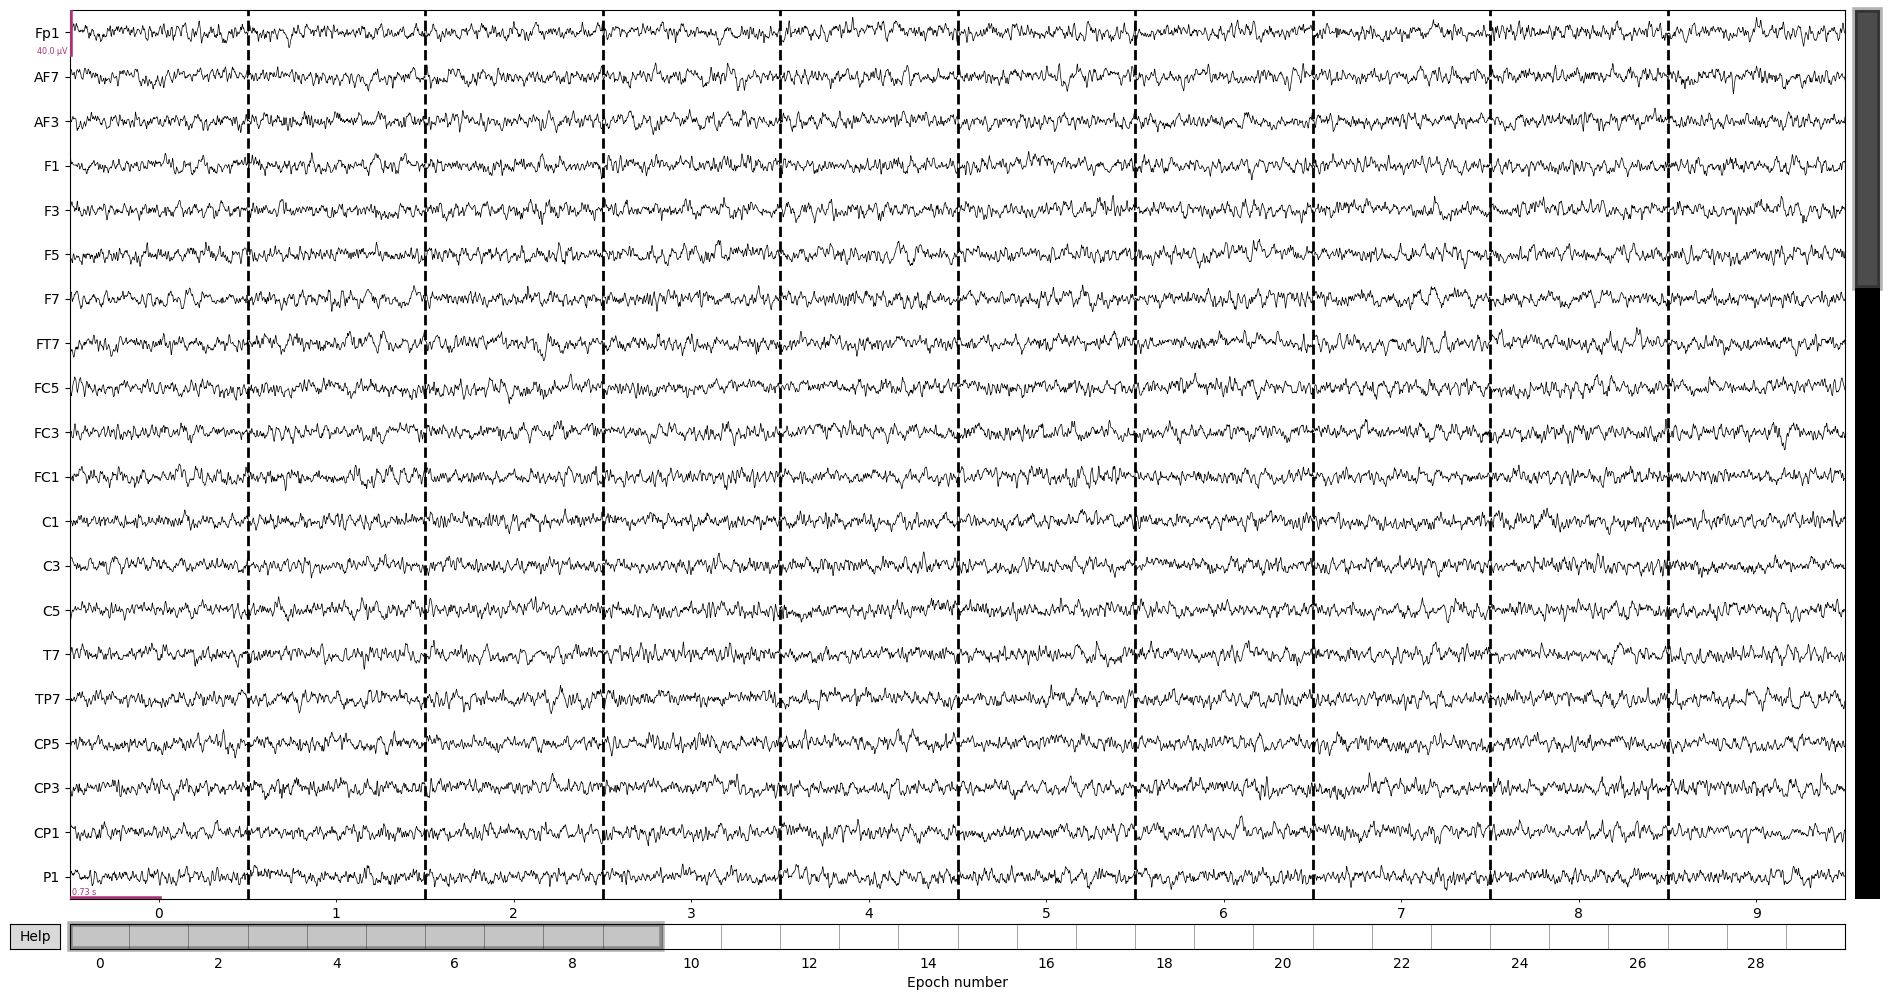

In [7]:
n_channels = EEG['data'].shape[0]
ch_names = EEG['nbchan_names']

sfreq = EEG['srate']
if isinstance(sfreq, np.ndarray):
    sfreq = sfreq.item()

info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types='eeg')

data = EEG['data']
data = np.transpose(data, (2, 0, 1))
data = data * 0.000004  # Convertir de µV a V

n_epochs = data.shape[0]
events = np.column_stack((np.arange(n_epochs), np.zeros(n_epochs, dtype=int), np.ones(n_epochs, dtype=int)))

epochs = mne.EpochsArray(data, info, events)

# Opción 2: Asignar el montaje estándar ignorando los canales faltantes
montage = mne.channels.make_standard_montage('standard_1020')
epochs.set_montage(montage, on_missing='ignore')

# Paso 3: Continuar con tus visualizaciones
epochs.plot(n_epochs=min(10, n_epochs), picks='eeg')

# Proyecciones de dipolos

In [8]:
mat_data = loadmat('emptyEEG.mat')
eeg_data = mat_data['EEG'][0, 0]
lf_data = mat_data['lf'][0, 0]
srate_value = eeg_data['srate'][0, 0]

# Obtener posiciones de electrodos desde `chanlocs`
chanlocs = eeg_data['chanlocs'][0]
ch_pos = {}
for loc in chanlocs:
    label = loc['labels'][0]  # Nombre del electrodo
    x = float(loc['X'][0][0])  # Coordenada X
    y = float(loc['Y'][0][0])  # Coordenada Y
    z = float(loc['Z'][0][0])  # Coordenada Z
    ch_pos[label] = [x, y, z]

# Crear la estructura de información de los electrodos
info = mne.create_info(ch_names=list(ch_pos.keys()), sfreq=srate_value, ch_types="eeg")
montage = mne.channels.make_dig_montage(ch_pos=ch_pos, coord_frame='head')
info.set_montage(montage)

# Proyecciones de los dipolos 109 y 409
dipolo_indices = [110 - 1, 410 - 1]  # Ajuste de índice para Python

# Crear figura para el gráfico 3D
fig = plt.figure(figsize=(10, 7))

# Gráfico 3D de las posiciones de los dipolos, resaltando los dipolos 109 y 409
ax3 = fig.add_subplot(1, 1, 1, projection='3d')
grid_loc = lf_data['GridLoc']
dipole1_pos = grid_loc[dipolo_indices[0]]
dipole2_pos = grid_loc[dipolo_indices[1]]

# Graficar todos los dipolos
ax3.scatter(grid_loc[:, 0], grid_loc[:, 1], grid_loc[:, 2], c='b', marker='o', label='All Dipoles')
# Graficar los dipolos seleccionados
ax3.scatter(dipole1_pos[0], dipole1_pos[1], dipole1_pos[2], c='g', marker='s', s=400, label=f'Dipole {dipolo_indices[0]} ')
ax3.scatter(dipole2_pos[0], dipole2_pos[1], dipole2_pos[2], c='r', marker='s', s=400, label=f'Dipole {dipolo_indices[1]}')

# Configuración del gráfico 3D
ax3.set_xlabel('X Coordinate')
ax3.set_ylabel('Y Coordinate')
ax3.set_zlabel('Z Coordinate')
ax3.legend()
ax3.set_title('Brain Dipole Locations')

# Mostrar la figura con el gráfico 3D
plt.show()

In [13]:
srate_value = 256#eeg_data['srate'][0, 0]
srate_value = np.int32(srate_value)
times_temp = np.arange(-srate_value, 2 * srate_value + 1)
eeg_data['times'] = times_temp / srate_value
eeg_data['pnts'] = np.array([[len(eeg_data['times'])]])
eeg_data['trials'] = 100;

In [14]:
eeg_data['data'] = np.zeros((eeg_data['nbchan'][0, 0], eeg_data['pnts'][0, 0], eeg_data['trials']))
gaus1 = np.exp(-4 * np.log(2) * (eeg_data['times'] - 0.8) ** 2)
gaus2 = np.exp(-4 * np.log(2) * (eeg_data['times'] - 0.9) ** 2 / 0.8)

In [15]:
diploc1 = dipolo_indices[0]
diploc2 = dipolo_indices[1]

# Asegúrate de que `EEG.trials`, `EEG.pnts`, `lf.Gain`, `diploc1`, `diploc2`, `EEG.srate`, `gaus1`, y `gaus2` estén definidos
for triali in range(eeg_data['trials']):
    # Comienza con actividad aleatoria del dipolo
    dipact = 0.02 * np.random.randn(lf_data['Gain'].shape[2], eeg_data['pnts'][0, 0])

    # Dipolo 1
    freqmod = 5 + 5 * np.interp(np.linspace(1, 10, eeg_data['pnts'][0, 0]), np.arange(1, 11), np.random.rand(10))
    IFsignal = np.sin(2 * np.pi * ((eeg_data['times'] + np.cumsum(freqmod)) / eeg_data['srate'][0, 0]))
    dipact[diploc1, :] = IFsignal * gaus1

    # Dipolo 2
    freqmod = 7 + 5 * np.interp(np.linspace(1, 10, eeg_data['pnts'][0, 0]), np.arange(1, 11), np.random.rand(10))
    IFsignal = np.sin(2 * np.pi * ((eeg_data['times'] + np.cumsum(freqmod)) / eeg_data['srate'][0, 0]))
    dipact[diploc2, :] = IFsignal * gaus2

    # Proyecta en el cuero cabelludo
    eeg_data['data'][:, :, triali] = np.squeeze(lf_data['Gain'][:, 0, :]) @ dipact
    
print(eeg_data['data'].shape)

(64, 769, 100)


In [16]:
# Configura los datos y los nombres de los canales
sfreq = 256#eeg_data['srate'][0, 0]  # Frecuencia de muestreo
n_channels = eeg_data['data'].shape[0]  # 64 canales
ch_names = [f'EEG {i+1}' for i in range(n_channels)]  # Nombres de los canales
ch_types = ['eeg'] * n_channels  # Define todos los canales como EEG

# Reshape los datos para (n_channels, n_times)
data = eeg_data['data'].reshape(n_channels, -1)

chanlocs = eeg_data['chanlocs'][0]
ch_names = [chan['labels'][0] if 'labels' in chan.dtype.names else f'EEG {i+1}' for i, chan in enumerate(chanlocs)]

# Crear RawArray y visualizar
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
raw = mne.io.RawArray(data, info)
raw.plot(scalings=dict(eeg=100), show=True)
mat_data['EEG'][0, 0]

# Configura los datos y los nombres de los canales
n_channels = eeg_data['data'].shape[0]  # 64 canales

Creating RawArray with float64 data, n_channels=64, n_times=76900
    Range : 0 ... 76899 =      0.000 ...   300.387 secs
Ready.
